In [1]:
from iris_helpers import sorted_vertices
import numpy as np
import matplotlib.pyplot as plt
from pydrake.all import MathematicalProgram, Solve
from pydrake.geometry.optimization import (
    HPolyhedron, VPolytope, Iris, IrisOptions, Hyperellipsoid)
from functools import partial
from dijkstraspp import DijkstraSPPsolver

In [2]:
iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 5
iris_options.termination_threshold = -1
iris_options.relative_termination_threshold = 0.05

dim = 2
domain = HPolyhedron.MakeBox([-10.] * dim, [10.] * dim)

def iris_mut_env(seed, obstacles, domain, iris_options):
    return Iris(obstacles, seed, domain, iris_options)

iris_handle_env = partial(iris_mut_env,
                      domain = domain, 
                      iris_options = iris_options)

In [3]:
from pydrake.geometry.optimization import IrisMultiContainment

(-11.0, 11.0, -11.042189224366735, 11.885973711701457)

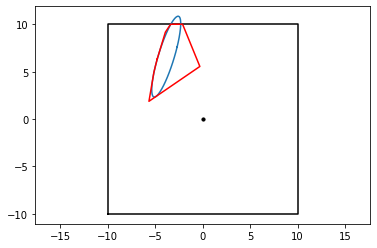

In [4]:
#generate random Polytope
def generate_random_poly(sa = 10, sb = 1):
    dim = 2
    maxsize = HPolyhedron.MakeBox([-10.] * dim, [10.] * dim)
    A = []
    b = []
    ax = np.random.uniform(1, sa)
    bx = np.random.uniform(0.5, sb)
    rot = np.random.uniform(0, np.pi)
    rmat =np.array([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]])
    E = rmat@np.array([[ax, 0], [0, bx]]) @rmat.T

    Einv = np.linalg.inv(E)
    numfaces = np.random.choice(8) + 7
    for idx in range(numfaces):
        a = np.random.uniform(0, 2*np.pi)
        dirrand = np.array([np.cos(a), np.sin(a)])
        A.append(Einv@dirrand)
        b.append(1.0)

    a = np.random.uniform(0, 2*np.pi)
    mag = np.random.uniform(0, 9)
    dirrand = np.array([np.cos(a), np.sin(a)])*mag 
    reg = HPolyhedron(np.array(A), np.array(b)+ np.array(A)@dirrand)
    region = maxsize.Intersection(reg)
    pts = np.array([E@np.array([np.cos(alph), np.sin(alph)]) + dirrand for alph in np.linspace(0,2*np.pi, 50)])
    return region, E, dirrand, pts

region, Ell, shift, pts = generate_random_poly()

fig, ax = plt.subplots()
ax.plot([-10, 10, 10, -10, -10], [-10, -10, 10, 10, -10], 'k')
ax.plot(pts[:,0], pts[:,1])
vert = sorted_vertices(VPolytope(region))
vert = np.hstack((vert, vert[:, :1]))
ax.plot(vert[0], vert[1], c = 'r')
ax.scatter([0],[0], c = 'k', s = 10)
ax.axis('equal')

(-11.0, 11.0, -11.0, 11.0)

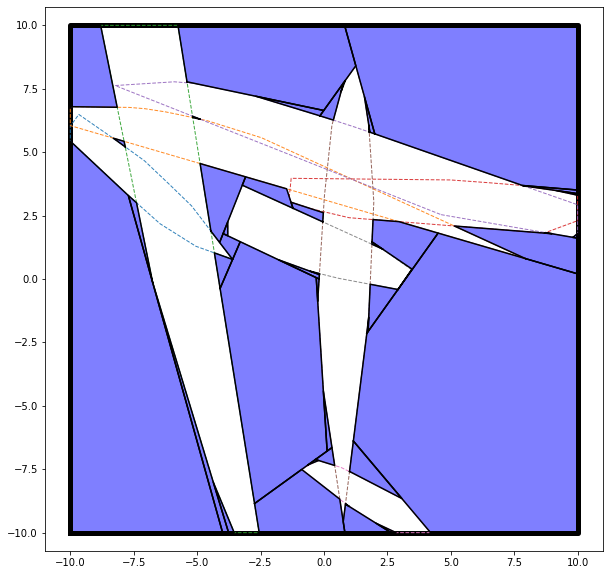

In [5]:
# generate environment
np.random.seed(26)
def generate_cfree(N): 
    region, Ell, shift, pts = generate_random_poly(sa = 10, sb = 0.9)
    regions = [region]
    for idx in range(N):
        while True:
            terminate = False
            r, E, dx, pts = generate_random_poly()
            for r2 in regions:
                if r.IntersectsWith(r2):
                    terminate = True
                    break
            if terminate:
                break
        regions.append(domain.Intersection(r))
    return regions
regions = generate_cfree(7)

def get_colliding_pt(cfree, obstacles):
    regs = cfree + obstacles
    good_sample = False #(not self.col_handle(pos_samp)) 
    for idx in range(10000):
        rand = np.random.rand(2)
        pos_samp = np.array([-10, -10]) + rand*np.array([20, 20])
        pt_inregions = False
        for r in regs:
            if r.PointInSet(pos_samp):
                pt_inregions = True
                break
        if not pt_inregions:
            return pos_samp
    return None

tries = 0
ret  = 0
obstacle_regions = []
while True:
    ret = get_colliding_pt(cfree = regions, obstacles = obstacle_regions)
    if ret is not None:
        obstacle_regions.append(iris_handle_env(ret, regions+obstacle_regions))
        #print('adding region')
    else:
        break    

def plot_env(ax, regions, obstacle_regions):
    ax.plot([-10, 10, 10, -10, -10], [-10, -10, 10, 10, -10], 'k', linewidth = 5)
    #ax.fill([-10, 10, 10, -10, -10], [-10, -10, 10, 10, -10], 'r', alpha = 0.5)
    
    #ax.plot(pts[:,0], pts[:,1])
    for r in regions:
        vert = sorted_vertices(VPolytope(r))
        vert = np.hstack((vert, vert[:, :1]))

        for idx in range(vert.shape[1]-1):
            #print('newvert')

            a = vert[:,idx]
            b = vert[:,idx+1]
            dist = np.linalg.norm(a-b)
            tval = np.linspace(0,1, int(dist*30)+20)
            piece = []
            for t in tval:
                pt = a*(1-t) + b * t
                in_other = False
                for r2 in regions:
                    if r2 != r and r2.PointInSet(pt):
                        in_other = True
                        break 

                if not in_other:
                    piece.append(pt)
            if len(piece):
                pts = np.array(piece)
                #ax.scatter(pts[:,0], pts[:,1])
                spacing = 1/50 *np.linalg.norm(a-b)

                curr_piece = [piece[0]]
                prev_draw = True
                for pt_idx in range(len(piece)-1):
                    b = piece[pt_idx+1]
                    a = piece[pt_idx]
                    close = np.linalg.norm(a-b)<1.5*spacing
                    if close:
                        curr_piece = [a, b]
                        pts = np.array(curr_piece)
                        #print('drawing')
                        #ax.plot(pts[:,0], pts[:,1], linewidth = 5, c = 'k', alpha = 0.6)#@, alpha = 0.8)
        #ax.fill(vert[0], vert[1], c = 'w')
        ax.plot(vert[0], vert[1],linewidth = 1, linestyle = 'dashed',alpha = 0.9)
        
    #ax.scatter([0],[0], c = 'k', s = 10)
    for r in obstacle_regions:
        vert = sorted_vertices(VPolytope(r))
        vert = np.hstack((vert, vert[:, :1]))
        ax.fill(vert[0], vert[1], c = 'b', alpha = 0.5)
        ax.plot(vert[0], vert[1], c = 'k')
        
fig, ax = plt.subplots(figsize = (10,10))     
plot_env(ax, regions, obstacle_regions)
ax.axis('equal')

In [6]:
def rand_point_in_regs(cfree_regs):
    good_sample = False #(not self.col_handle(pos_samp)) 
    mindist = np.array([-10, -10])
    minmaxdiff = np.array([20, 20])
    for idx in range(10000):
        rand = np.random.rand(2)
        pos_samp = mindist + rand*minmaxdiff
        pt_inregions = False
        for r in cfree_regs:
            if r.PointInSet(pos_samp):
                pt_inregions = True
                break
        if pt_inregions:
            return pos_samp
    return None

def point_in_regions(pt, regions): 
    for r in regions:
        if r.PointInSet(pt):
            return True
    return False 

def collision(pt, obs, eps = 0.3):
    for r in obs:
        for idx in range(10):
            p = pt + eps*(np.random.rand(dim)-0.5)
            if r.PointInSet(p):
                return True
    return False

col_handle = partial(collision, obs=obstacle_regions)

def is_los(q1, q2, cfree, domain):
    if not domain.PointInSet(q1) or not domain.PointInSet(q2):
        return False, []
    tval = np.linspace(0,1, 40)
    for t in tval:
        pt = (1-t)*q1 + t* q2
        if not point_in_regions(pt, cfree):
            return False, []
    return True, []

los_handle = partial(is_los, cfree = regions, domain = domain)

iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 5
iris_options.termination_threshold = -1
iris_options.relative_termination_threshold = 0.05

dim = 2
domain = HPolyhedron.MakeBox([-10.] * dim, [10.] * dim)

def iris_mut(seed, obstacles, domain, iris_options):
    return Iris(obstacles, seed, domain, iris_options)

iris_handle = partial(iris_mut, obstacles = obstacle_regions,
                      domain = domain, 
                      iris_options = iris_options)

#treat other regions as obstacles 
def morph_iris2(pt, regions, obstacles, domain, options):
    obs = [o for o in obstacles]
    for r in regions:
        offset = 0.25*np.min(1/np.linalg.eig(r.MaximumVolumeInscribedEllipsoid().A())[0])
        rnew = HPolyhedron(r.A(), r.b()-offset)
        obs.append(rnew)
    return Iris(obs, pt, domain, iris_options)

iris_handle2 = partial(morph_iris2, 
                      obstacles = obstacle_regions, 
                      domain = domain, 
                      options = iris_options)   

def get_cover_est(cover, cfree, N = 10000):
    ntot = 0
    for idx in range(N):
        pt=rand_point_in_regs(cfree)
        if point_in_regions(pt, cover):
            ntot +=1
    return ntot*1.0/N

In [7]:
def generate_env_and_helperfunctions(seed):
    np.random.seed(seed)
    cfreepieces = np.random.randint(4,7)
    regions = generate_cfree(cfreepieces)
    tries = 0
    ret  = 0
    obstacle_regions = []
    while True:
        ret = get_colliding_pt(cfree = regions, obstacles = obstacle_regions)
        if ret is not None:
            obstacle_regions.append(iris_handle_env(ret, regions+obstacle_regions))
            #print('adding region')
        else:
            break 
    col_handle = partial(collision, obs=obstacle_regions)
    los_handle = partial(is_los, cfree = regions, domain = domain)
    iris_handle = partial(iris_mut, obstacles = obstacle_regions,
                      domain = domain, 
                      iris_options = iris_options)
    iris_handle2 = partial(morph_iris2, 
                      obstacles = obstacle_regions, 
                      domain = domain, 
                      options = iris_options)
    return regions, obstacle_regions, col_handle, los_handle, iris_handle, iris_handle2

In [8]:
# investigating using the kernel to grow regions
from visprm import VPRMSeeding
#poi = [np.array([-6, 0]), np.array([0, 8]), np.array([4, -7.5])]
#np.random.seed(12)
seed = 11
regions, obstacle_regions, col_handle, los_handle, iris_handle, iris_handle2 = generate_env_and_helperfunctions(seed)
vs = VPRMSeeding([],
                 alpha = 0.05,
                 eps = 0.05,
                 limits = [np.array([-10.] * dim), np.array([10.] * dim)],# [lb, ub],
                 collision_handle = col_handle,
                 is_in_line_of_sight = los_handle, 
                 iris_handle=iris_handle,
                 iris_handle_with_obstacles = iris_handle2,
                 )

[21:32:22] [VPRMSeeding] Expecting points of interest in q
[21:32:22] [VPRMSeeding] GuardInsertion attempts M: 58
[21:32:22] [VPRMSeeding] 0.95 probability that unseen region is less than 5.0 "%" of Cfree 


In [9]:
vs.guard_phase()

[21:32:22] [VPRMSeeding] New guard placed N =  0 it =  0
[21:32:23] [VPRMSeeding] Sample set size 0
[21:32:23] [VPRMSeeding] New guard placed N =  1 it =  5
[21:32:25] [VPRMSeeding] Sample set size 4
[21:32:25] [VPRMSeeding] New guard placed N =  2 it =  6
[21:32:26] [VPRMSeeding] Sample set size 9


In [10]:
vs.refine_guards()

[21:32:27] [VPRMSeeding] Guard found to split
[21:32:27] [VPRMSeeding] N =  1  guards to split
[21:32:30] [VPRMSeeding] New guard placed N =  4 it =  5
[21:32:32] [VPRMSeeding] Sample set size 71
[21:32:33] [VPRMSeeding] No guard to split


In [11]:
# keep_splitting = True
# while keep_splitting:
#     to_split = refine_guards1(vs)
#     if len(to_split):
#         #goi, targ_seed, ker, g1, g2 = to_split[0]
#         refine_guards2(vs, to_split)
#         vs.guard_phase()
#         keep_splitting = True
#     else:
#         keep_splitting = False
def conv(a):
    return a

dspp = DijkstraSPPsolver(vs.regions, conv)

[DijkstraSPP] Pre-Building adjacency matrix  0 / 5


In [12]:
kers = [vs.compute_kernel_of_guard(g) for g in vs.guard_regions]
kers = [k + [vs.seed_points[g]] for k,g in zip(kers, vs.guard_regions)]

min convex cover: 6 regions, guard_regions: 5  regions
Estimated cover of cfree =  0.9607 (N = 10000 )


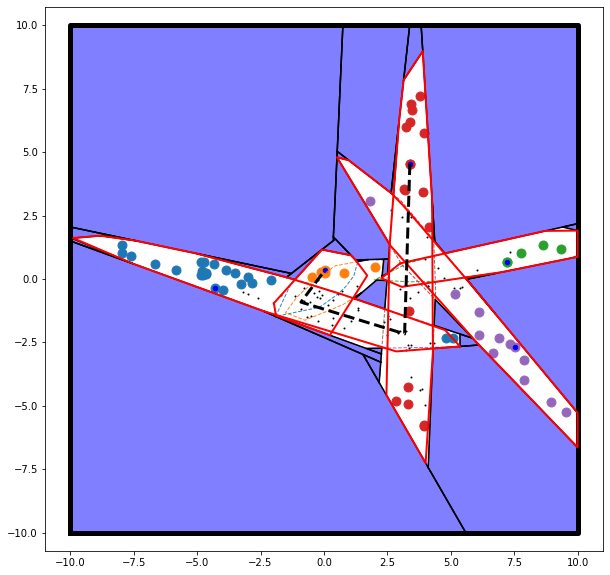

In [15]:
fig, ax = plt.subplots(figsize = (10,10))
guards = np.array([vs.seed_points[s] for s in vs.guard_regions])
guard_regions = [vs.regions[r] for r in vs.guard_regions]
guard_reg_verts =[]
for g in guard_regions:
    vert = sorted_vertices(VPolytope(g))
    vert = np.hstack((vert, vert[:, :1]))
    guard_reg_verts.append(vert)
sample_set = []
for sampdat in vs.samples_outside_regions.values():
    pos = sampdat[0]
    sample_set.append(pos)
sample_set = np.array(sample_set)   

print('min convex cover:', len(regions), 'regions, guard_regions:', len(vs.guard_regions), ' regions')
N_cover = 10000
cover_est = get_cover_est(guard_regions, regions, N = N_cover)
print('Estimated cover of cfree = ', cover_est, '(N =', N_cover,')')

plot_env(ax, regions, obstacle_regions)
ax.axis('equal')
for r in guard_reg_verts:
    ax.plot(r[0, :], r[1, :], c = 'r', linewidth = 2)

if len(sample_set):
    ax.scatter(sample_set[:, 0], sample_set[:, 1], c = 'k', s = 1)
# if len(to_split):
#     ax.scatter(targ_seed[0], targ_seed[1], c = 'm', s = 50)
#     ax.scatter(np.array([g1, g2])[-2:, 0], np.array([g1, g2])[-2:, 1], c = 'r', s = 40)
# kers = []
for k in kers:
    pts = np.array(k)
    ax.scatter(pts[:,0], pts[:,1], s= 80)
ax.scatter(guards[:, 0], guards[:, 1], c = 'b', s = 20)
wps_spp, dist = dspp.solve(guards[-2], guards[-4], refine_path = False)
wps_spp = np.array(wps_spp)

ax.plot(wps_spp[:,0], wps_spp[:,1], c = 'k', linewidth = 3, linestyle = 'dashed')

plt.show()

In [16]:
dist


12.565639992517543

In [26]:
self= dspp
start_q = guards[-2]
target_q = guards[-4]
ad_mat = self.extend_adjacency_mat(start_q, target_q)
wps, dist = self.dijkstra_in_configspace(adj_mat=ad_mat)

In [39]:
from pydrake.all import (MathematicalProgram, Variable, HPolyhedron, le, SnoptSolver, Solve, eq) 
start_t = guards[-2]
target_t = guards[-4]

intermediate_nodes = [self.node_intersections[idx] for idx in wps[1:-1]]
dim = len(self.node_intersections[0].loc)
prog = MathematicalProgram()
intermediates = []
for idx, wpnode in enumerate(intermediate_nodes):
    x = prog.NewContinuousVariables(dim, 'x'+str(idx))
    intermediates.append(x)
    prog.SetInitialGuess(x, wpnode.loc)
    for r in wpnode.regions:
        prog.AddConstraint(le(r.A()@x, r.b())) 
prev = start_t
cost = 0 
for idx in range(len(intermediate_nodes)+1):
    t = prog.NewContinuousVariables(dim+1, 't'+str(idx))
    prog.AddConstraint(eq(t[1:], prev-(intermediates + [target_t])[idx]))
    prev = (intermediates + [target_t])[idx]
    prog.AddLorentzConeConstraint(t)
    cost += t[0]
    
# prev = start_t
# for pt in intermediates + [target_t]:
#     a = (prev-pt) #* np.array([4.0,3.5,3,2.5,2,2.5,1]) 
#     cost += np.sqrt(a.T@a)
#     prev = pt
prog.AddCost(cost)

res = Solve(prog)
if res.is_success():
    path = [start_t]
    for i in intermediates:
        path.append(res.GetSolution(i))
    path.append(target_t)
    wps_start = [self.node_intersections[idx].loc for idx in wps[1:-1]]
    dist_start = 0
    prev = start_t
    for wp in wps_start + [target_t]:
        #dist_start += np.linalg.norm()#* np.array([4.0,3.5,3,2.5,2,2.5,1])
        a = prev-wp
        dist_start += np.sqrt(a.T@a)
        prev = wp
    if self.verbose: print("[DijkstraSPP] optimized distance/ start-distance = {opt:.2f} / {start:.2f} = {res:.2f}".format(opt = res.get_optimal_cost(), start = dist_start, res = res.get_optimal_cost()/dist_start))

#refine_path_SOCP(dspp, wps_spp, guards[-2], guards[-4])

[DijkstraSPP] optimized distance/ start-distance = 8.87 / 12.57 = 0.71


In [40]:
np.linalg.norm(guards[-2]- guards[-4])

5.348133173339972

In [14]:
fig, ax = plt.subplots(figsize = (10,10))
guards = np.array([vs.seed_points[s] for s in vs.guard_regions])
guard_regions = [vs.regions[r] for r in vs.guard_regions]
guard_reg_verts =[]
for g in guard_regions:
    vert = sorted_vertices(VPolytope(g))
    vert = np.hstack((vert, vert[:, :1]))
    guard_reg_verts.append(vert)
sample_set = []
for sampdat in vs.samples_outside_regions.values():
    pos = sampdat[0]
    sample_set.append(pos)
sample_set = np.array(sample_set)   

print('min convex cover:', len(regions), 'regions, guard_regions:', len(vs.guard_regions), ' regions')
N_cover = 10000
cover_est = get_cover_est(guard_regions, regions, N = N_cover)
print('Estimated cover of cfree = ', cover_est, '(N =', N_cover,')')

plot_env(ax, regions, obstacle_regions)
ax.axis('equal')
for r in guard_reg_verts:
    ax.plot(r[0, :], r[1, :], c = 'r', linewidth = 2)

if len(sample_set):
    ax.scatter(sample_set[:, 0], sample_set[:, 1], c = 'k', s = 1)
# if len(to_split):
#     ax.scatter(targ_seed[0], targ_seed[1], c = 'm', s = 50)
#     ax.scatter(np.array([g1, g2])[-2:, 0], np.array([g1, g2])[-2:, 1], c = 'r', s = 40)
# kers = []
for k in kers:
    pts = np.array(k)
    ax.scatter(pts[:,0], pts[:,1], s= 80)
ax.scatter(guards[:, 0], guards[:, 1], c = 'b', s = 20)
wps_spp, dist = dspp.solve(guards[-2], guards[-4], refine_path = False)
wps_spp = np.array(wps_spp)

ax.plot(wps_spp[:,0], wps_spp[:,1], c = 'k', linewidth = 3, linestyle = 'dashed')

plt.show()


45

In [18]:
def switch_ellipse_description(A, b):
    d = np.linalg.solve(A.T@A, -A.T@b)
    return Hyperellipsoid(A,d), A, d

def get_lj_ellipse(pts, eps = 0.01):
    dim = pts[0].shape[0]
    prog = MathematicalProgram()
    A = prog.NewSymmetricContinuousVariables(dim, 'A')
    b = prog.NewContinuousVariables(dim, 'b')
    prog.AddMaximizeLogDeterminantCost(A)
    for idx, pt in enumerate(pts):
        S = prog.NewSymmetricContinuousVariables(dim+1, 'S')
        prog.AddPositiveSemidefiniteConstraint(S)
        prog.AddLinearEqualityConstraint(S[0,0] == 1)
        v = (A@pt.reshape(-1,1) + b.reshape(dim,1)).T
        c = (S[1:,1:]-np.eye(dim)).reshape(-1)
        for idx in range(dim):
            prog.AddLinearEqualityConstraint(S[0,1 + idx]-v[0,idx], 0 )
        for ci in c:
            prog.AddLinearEqualityConstraint(ci, 0 )

    prog.AddPositiveSemidefiniteConstraint(A)

    sol = Solve(prog)
    if sol.is_success():
        return switch_ellipse_description(sol.GetSolution(A), sol.GetSolution(b))
    else:
        return None, None, None
    
def plot_ellipse(ax, A, center, n_samples = 100):
    angs = np.linspace(0, 2*np.pi, n_samples+1)
    coords = np.zeros((2, n_samples + 1))
    coords[0, :] = np.cos(angs)
    coords[1, :] = np.sin(angs)
    Bu = np.linalg.inv(A)@coords
    pts = Bu + center.reshape(2,1)
    ax.plot(pts[0, :], pts[1, :], linewidth = 1)

In [25]:
pts_ell = np.array(kers[2])
HE, AE,dE = get_lj_ellipse(pts_ell)
reg_kernel = IrisMultiContainment(obstacle_regions, np.array([guards[0]]), HE, domain, iris_options)
if reg_kernel == domain:
    print('failed')
#reg_kernel = Iris(obstacle_regions, pts_ell[0], domain, iris_options)
reg_kernel_vert = sorted_vertices(VPolytope(reg_kernel))
reg_kernel_vert = np.hstack((reg_kernel_vert, reg_kernel_vert[:, :1]))

In [26]:
reg_kernel.A()



array([[ 1.,  0.],
       [ 0.,  1.],
       [-1., -0.],
       [-0., -1.]])

min convex cover: 6 regions, guard_regions: 5  regions
Estimated cover of cfree =  0.9597 (N = 10000 )


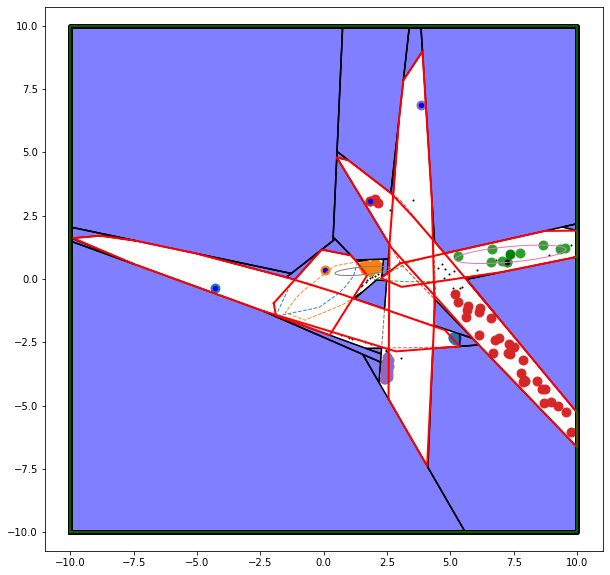

In [27]:
fig, ax = plt.subplots(figsize = (10,10))

guards = np.array([vs.seed_points[s] for s in vs.guard_regions])
guard_regions = [vs.regions[r] for r in vs.guard_regions]
guard_reg_verts =[]
for g in guard_regions:
    vert = sorted_vertices(VPolytope(g))
    vert = np.hstack((vert, vert[:, :1]))
    guard_reg_verts.append(vert)
sample_set = []
for sampdat in vs.samples_outside_regions.values():
    pos = sampdat[0]
    sample_set.append(pos)
sample_set = np.array(sample_set)   

print('min convex cover:', len(regions), 'regions, guard_regions:', len(vs.guard_regions), ' regions')
N_cover = 10000
cover_est = get_cover_est(guard_regions, regions, N = N_cover)
print('Estimated cover of cfree = ', cover_est, '(N =', N_cover,')')

plot_env(ax, regions, obstacle_regions)
ax.axis('equal')
for r in guard_reg_verts:
    ax.plot(r[0, :], r[1, :], c = 'r', linewidth = 2)

if len(sample_set):
    ax.scatter(sample_set[:, 0], sample_set[:, 1], c = 'k', s = 1)
# if len(to_split):
#     ax.scatter(targ_seed[0], targ_seed[1], c = 'm', s = 50)
#     ax.scatter(np.array([g1, g2])[-2:, 0], np.array([g1, g2])[-2:, 1], c = 'r', s = 40)
# kers = []
for k in kers:
    pts = np.array(k)
    ax.scatter(pts[:,0], pts[:,1], s= 80)
ax.scatter(guards[:, 0], guards[:, 1], c = 'b', s = 20)

#ax.scatter(pts_ell[:, 0], pts_ell[:, 1], c = 'r', s = 80)
ax.scatter(pts_ell[0, 0], pts_ell[0, 1], c = 'k', s = 20)
plot_ellipse(ax, AE, dE)
plot_ellipse(ax, AE*2, dE- (1-1/2)*(dE-guards[0]))
ax.scatter(dE[0], dE[1], c = 'g', s=80)
ax.plot(reg_kernel_vert[0,:],reg_kernel_vert[1,], c = 'g')
plt.show()

In [24]:
from visprm import VPRMSeeding
#poi = [np.array([-6, 0]), np.array([0, 8]), np.array([4, -7.5])]
#np.random.seed(12)
regions, obstacle_regions, col_handle, los_handle, iris_handle, iris_handle2 = generate_env_and_helperfunctions(15)
vs = VPRMSeeding([],
                 alpha = 0.05,
                 eps = 0.05,
                 limits = [np.array([-10.] * dim), np.array([10.] * dim)],# [lb, ub],
                 collision_handle = col_handle,
                 is_in_line_of_sight = los_handle, 
                 iris_handle=iris_handle,
                 iris_handle_with_obstacles = iris_handle2,
                 )


[18:52:42] [VPRMSeeding] Expecting points of interest in q
[18:52:42] [VPRMSeeding] GuardInsertion attempts M: 58
[18:52:42] [VPRMSeeding] 0.95 probability that unseen region is less than 5.0 "%" of Cfree 


In [25]:
vs.guard_phase()

[18:52:42] [VPRMSeeding] New guard placed N =  0 it =  0
[18:52:44] [VPRMSeeding] Sample set size 0
[18:52:44] [VPRMSeeding] New guard placed N =  1 it =  1
[18:52:46] [VPRMSeeding] Sample set size 0
[18:52:47] [VPRMSeeding] New guard placed N =  2 it =  4
[18:52:49] [VPRMSeeding] Sample set size 3
[18:52:49] [VPRMSeeding] New guard placed N =  3 it =  15
[18:52:51] [VPRMSeeding] Sample set size 17


In [26]:
guards = np.array([vs.seed_points[s] for s in vs.guard_regions])
guard_regions = [vs.regions[r] for r in vs.guard_regions]
guard_reg_verts =[]
for g in guard_regions:
    vert = sorted_vertices(VPolytope(g))
    vert = np.hstack((vert, vert[:, :1]))
    guard_reg_verts.append(vert)
sample_set = []
for sampdat in vs.samples_outside_regions.values():
    pos = sampdat[0]
    sample_set.append(pos)
sample_set = np.array(sample_set)   
print(len(sample_set))

74


In [37]:
kers = [vs.compute_kernel_of_guard(g) for g in vs.guard_regions]
kers = [k + [vs.seed_points[g]] for k,g in zip(kers, vs.guard_regions)]

min convex cover: 5 regions, guard_regions: 5  regions
Estimated cover of cfree =  0.775 (N = 10000 )


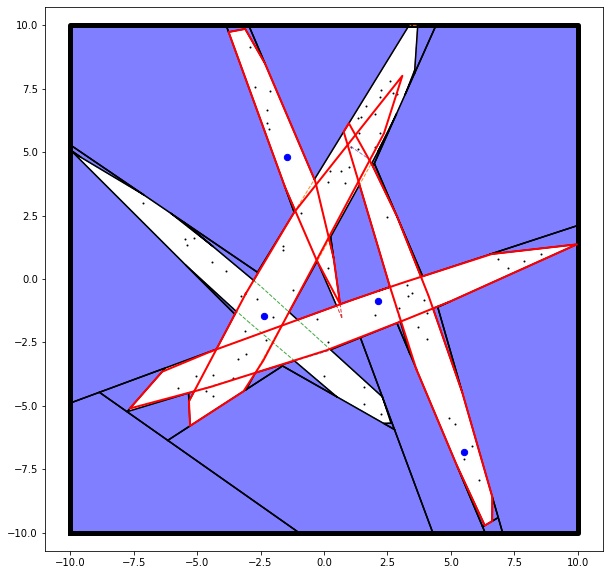

In [40]:
print('min convex cover:', len(regions), 'regions, guard_regions:', len(vs.guard_regions), ' regions')
N_cover = 10000
cover_est = get_cover_est(guard_regions, regions, N = N_cover)
print('Estimated cover of cfree = ', cover_est, '(N =', N_cover,')')
fig, ax = plt.subplots(figsize = (10,10))
plot_env(ax, regions, obstacle_regions)
ax.axis('equal')
for r in guard_reg_verts:
    ax.plot(r[0, :], r[1, :], c = 'r', linewidth = 2)
ax.scatter(guards[:, 0], guards[:, 1], c = 'b', s = 40)
#ax.scatter(guards[0, 0], guards[0, 1], c = 'm', s = 40)
if len(sample_set):
    ax.scatter(sample_set[:, 0], sample_set[:, 1], c = 'k', s = 1)
# for k in kers:
#     pts = np.array(k)
#     ax.scatter(pts[:,0], pts[:,1], s= 80)
plt.show()


In [28]:
to_split = refine_guards1(vs)
if len(to_split):
    goi, targ_seed, ker, g1, g2 = to_split[0]
refine_guards2(vs, to_split)
if len(to_split):
    vs.guard_phase()

[VPRMSeeding] Guard found to split
[VPRMSeeding] N =  1  guards to split
[VPRMSeeding] Splitting guard 


min convex cover: 5 regions, guard_regions: 5  regions
Estimated cover of cfree =  0.7752 (N = 10000 )


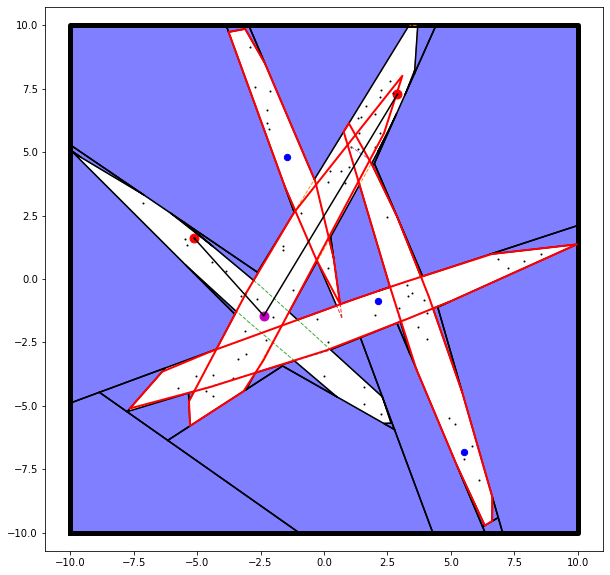

In [42]:
#do plotting
print('min convex cover:', len(regions), 'regions, guard_regions:', len(vs.guard_regions), ' regions')
N_cover = 10000
cover_est = get_cover_est(guard_regions, regions, N = N_cover)
print('Estimated cover of cfree = ', cover_est, '(N =', N_cover,')')
fig, ax = plt.subplots(figsize = (10,10))
plot_env(ax, regions, obstacle_regions)
ax.axis('equal')
for r in guard_reg_verts:
    ax.plot(r[0, :], r[1, :], c = 'r', linewidth = 2)
ax.scatter(guards[:, 0], guards[:, 1], c = 'b', s = 40)
if len(to_split):
    ax.scatter(targ_seed[0], targ_seed[1], c = 'm', s = 80)
    ax.scatter(np.array([g1, g2])[-2:, 0], np.array([g1, g2])[-2:, 1], c = 'r', s = 80)
    ax.plot(np.array([ g1, targ_seed,g2])[-3:, 0], np.array([g1,targ_seed,  g2])[-3:, 1], c = 'k')
    
if len(sample_set):
    ax.scatter(sample_set[:, 0], sample_set[:, 1], c = 'k', s = 1)
plt.show()


In [43]:
np.array([targ_seed, g1, g2])[-3:, 0]

array([-2.37235655, -5.12929615,  2.89661932])

In [44]:
guards = np.array([vs.seed_points[s] for s in vs.guard_regions])
guard_regions = [vs.regions[r] for r in vs.guard_regions]
guard_reg_verts =[]
for g in guard_regions:
    vert = sorted_vertices(VPolytope(g))
    vert = np.hstack((vert, vert[:, :1]))
    guard_reg_verts.append(vert)
sample_set = []
for sampdat in vs.samples_outside_regions.values():
    pos = sampdat[0]
    sample_set.append(pos)
sample_set = np.array(sample_set)    


min convex cover: 5 regions, guard_regions: 5  regions
Estimated cover of cfree =  0.9847 (N = 10000 )


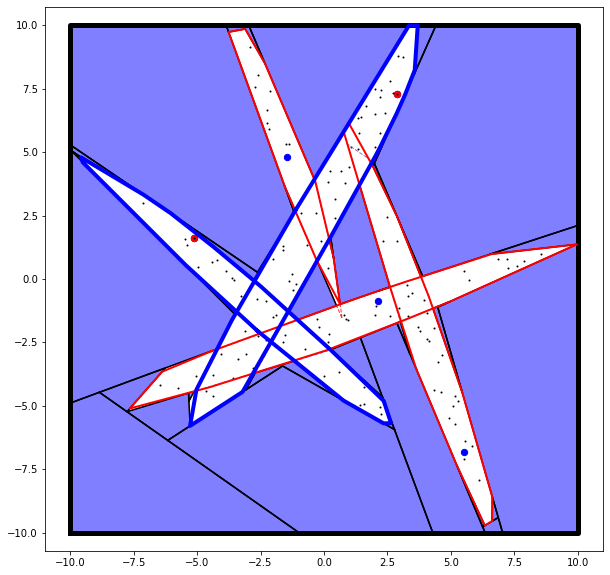

In [49]:
print('min convex cover:', len(regions), 'regions, guard_regions:', len(vs.guard_regions), ' regions')
N_cover = 10000
cover_est = get_cover_est(guard_regions, regions, N = N_cover)
print('Estimated cover of cfree = ', cover_est, '(N =', N_cover,')')
fig, ax = plt.subplots(figsize = (10,10))
plot_env(ax, regions, obstacle_regions)
ax.axis('equal')
for r in guard_reg_verts:
    ax.plot(r[0, :], r[1, :], c = 'r', linewidth = 2)
for r in guard_reg_verts[-2:]:
    ax.plot(r[0, :], r[1, :], c = 'b', linewidth = 4)
ax.scatter(guards[:, 0], guards[:, 1], c = 'b', s = 40)
ax.scatter(guards[-2:, 0], guards[-2:, 1], c = 'r', s = 40)
ax.scatter(sample_set[:, 0], sample_set[:, 1], c = 'k', s = 1)
plt.show()


In [17]:
vs.fill_remaining_space_phase()

[16:16:13] [VPRMSeeding] New Region placed N =  5 , it =  6
[16:16:16] [VPRMSeeding] New Region placed N =  6 , it =  13
[16:16:17] [VPRMSeeding] New Region placed N =  7 , it =  15
[16:16:19] [VPRMSeeding] New Region placed N =  8 , it =  17
[16:16:20] [VPRMSeeding] New Region placed N =  9 , it =  12
[16:16:23] [VPRMSeeding] New Region placed N =  10 , it =  7
[16:16:26] [VPRMSeeding] New Region placed N =  11 , it =  43
[16:16:27] [VPRMSeeding] New Region placed N =  12 , it =  11
[16:16:30] [VPRMSeeding] New Region placed N =  13 , it =  12
[16:16:31] [VPRMSeeding] New Region placed N =  14 , it =  0
[16:16:34] [VPRMSeeding] New Region placed N =  15 , it =  21


True

In [18]:
all_regs = vs.regions
guards = np.array([vs.seed_points[s] for s in vs.guard_regions])
guard_regions = [vs.regions[r] for r in vs.guard_regions]

all_reg_verts =[]
for g in all_regs:
    vert = sorted_vertices(VPolytope(g))
    vert = np.hstack((vert, vert[:, :1]))
    all_reg_verts.append(vert)
    
sample_set = []
for sampdat in vs.samples_outside_regions.values():
    pos = sampdat[0]
    sample_set.append(pos)
sample_set = np.array(sample_set)    

min convex cover: 8 regions, guard_regions: 5  regions
regions placed: 16
Estimated cover of cfree =  0.9728 (N = 10000 )


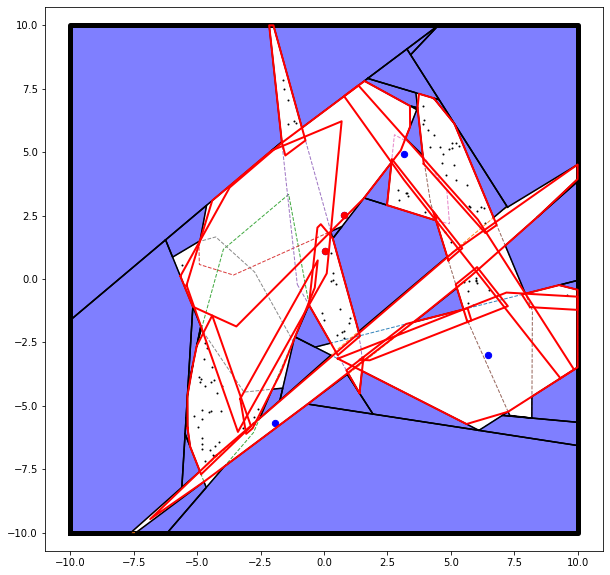

In [19]:
print('min convex cover:', len(regions), 'regions, guard_regions:', len(vs.guard_regions), ' regions')
print('regions placed:', len(vs.regions))
N_cover = 10000
cover_est = get_cover_est(all_regs, regions, N = N_cover)
print('Estimated cover of cfree = ', cover_est, '(N =', N_cover,')')
fig, ax = plt.subplots(figsize = (10,10))
plot_env(ax, regions, obstacle_regions)
ax.axis('equal')
for r in all_reg_verts:
    ax.plot(r[0, :], r[1, :], c = 'r', linewidth = 2)
ax.scatter(guards[:, 0], guards[:, 1], c = 'b', s = 40)
ax.scatter(guards[-2:, 0], guards[-2:, 1], c = 'r', s = 40)
if len(sample_set):
    ax.scatter(sample_set[:, 0], sample_set[:, 1], c = 'k', s = 1)
plt.show()


In [20]:
from visprm import RandSeeding

rs = RandSeeding([],
              alpha = 0.1,
              eps = 0.01,
              limits = [np.array([-10.] * dim), np.array([10.] * dim)],
              collision_handle = col_handle,
              iris_handle=iris_handle,
              iris_handle_with_obstacles = iris_handle2,
              terminate_early = False)
rs.set_init_regions()

[16:16:38] [RandSeeding] Expecting points of interest in q
[16:16:38] [RandSeeding] GuardInsertion attempts M: 229
[16:16:38] [RandSeeding] 0.9 probability that unseen region is less than 1.0 "%" of Cfree 


In [21]:
rs.sample_regions_phase()

[16:16:38] [RandSeeding] New Region placed N =  0 , it =  0
[16:16:39] [RandSeeding] New Region placed N =  1 , it =  0
[16:16:40] [RandSeeding] New Region placed N =  2 , it =  2
[16:16:42] [RandSeeding] New Region placed N =  3 , it =  2
[16:16:44] [RandSeeding] New Region placed N =  4 , it =  0
[16:16:45] [RandSeeding] New Region placed N =  5 , it =  2
[16:16:47] [RandSeeding] New Region placed N =  6 , it =  1
[16:16:49] [RandSeeding] New Region placed N =  7 , it =  2
[16:16:52] [RandSeeding] New Region placed N =  8 , it =  0
[16:16:55] [RandSeeding] New Region placed N =  9 , it =  9
[16:16:57] [RandSeeding] New Region placed N =  10 , it =  49
[16:16:58] [RandSeeding] New Region placed N =  11 , it =  8
[16:17:00] [RandSeeding] New Region placed N =  12 , it =  13
[16:17:02] [RandSeeding] New Region placed N =  13 , it =  22
[16:17:03] [RandSeeding] New Region placed N =  14 , it =  15
[16:17:05] [RandSeeding] New Region placed N =  15 , it =  17
[16:17:08] [RandSeeding] New 

False

min convex cover: 8 regions, rand regions: 17  regions
Estimated cover of cfree =  0.952 (N = 10000 )


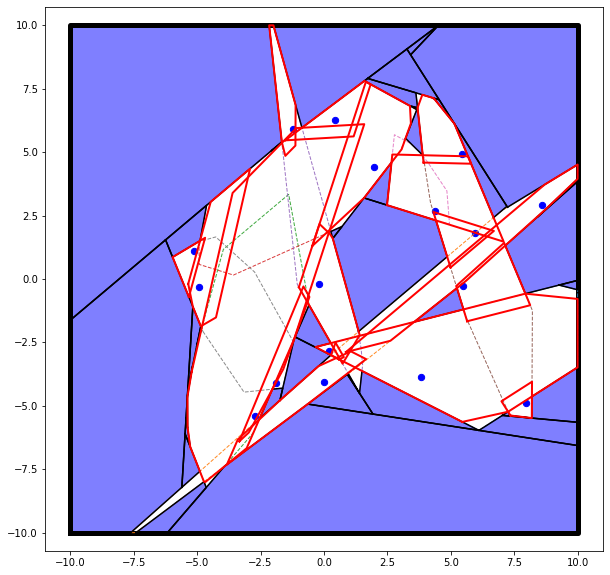

In [22]:
print('min convex cover:', len(regions), 'regions, rand regions:', len(rs.regions), ' regions')
seeds_rand = np.array(rs.seed_points)
regions_rand = [r for r in rs.regions]
N_cover = 10000
cover_est = get_cover_est(regions_rand, regions, N = N_cover)
print('Estimated cover of cfree = ', cover_est, '(N =', N_cover,')')
reg_verts_rand =[]
for g in regions_rand:
    vert = sorted_vertices(VPolytope(g))
    vert = np.hstack((vert, vert[:, :1]))
    reg_verts_rand.append(vert)

fig, ax = plt.subplots(figsize = (10,10))
plot_env(ax, regions, obstacle_regions)
ax.axis('equal')
for r in reg_verts_rand:
    ax.plot(r[0, :], r[1, :], c = 'r', linewidth = 2)
ax.scatter(seeds_rand[:, 0], seeds_rand[:, 1], c = 'b', s = 40)
plt.show()

In [23]:
#EVALLL

In [357]:
from datetime import date, datetime
import time
from visprm import RandSeeding
now = datetime.now()
timestamp = now.strftime("%y_%m_%d_%H_%M_%S")
filename = timestamp+'_2d_randenv_eval_uisng_fill_remaining_space.log'
with open(filename, 'w+') as file:  
    for i in range(100):
        np.random.seed(i)
        #generate env
        regions, obstacle_regions, col_handle, los_handle, \
        iris_handle, iris_handle2 = generate_env_and_helperfunctions(i)
        vs = VPRMSeeding([],
                     alpha = 0.05,
                     eps = 0.1,
                     limits = [np.array([-10.] * dim), np.array([10.] * dim)],# [lb, ub],
                     collision_handle = col_handle,
                     is_in_line_of_sight = los_handle, 
                     iris_handle=iris_handle,
                     iris_handle_with_obstacles = iris_handle2,
                     )

        t1 = time.time()
        vs.guard_phase()
        vs.fill_remaining_space_phase()
        t2 = time.time()
        coverage = get_cover_est(vs.regions, regions, N = 10000)
        coverage_guards = get_cover_est([vs.regions[g] for g in vs.guard_regions], regions, N = 10000)
        run_string = [(f"""{'--visprmraw'},\n"""),
                     (f"""{ 'seed:'}{i},\n"""),
                     (f"""{'nr: '}{len(vs.regions)},\n"""),
                     (f"""{'ng: '}{len(vs.guard_regions)},\n"""),
                     (f"""{'coverage: '}{coverage:.4f},\n"""),
                     (f"""{'coverage_guards: '}{coverage_guards:.4f},\n"""),
                     (f"""{'runtime: '}{t2-t1:.4f},\n"""),
                     (f"""{'optcover: '}{len(regions)},\n"""),
                     ]
        file.writelines(run_string)
        
        vs = VPRMSeeding([],
                     alpha = 0.05,
                     eps = 0.1,
                     limits = [np.array([-10.] * dim), np.array([10.] * dim)],# [lb, ub],
                     collision_handle = col_handle,
                     is_in_line_of_sight = los_handle, 
                     iris_handle=iris_handle,
                     iris_handle_with_obstacles = iris_handle2,
                     )

        t1 = time.time()
        vs.guard_phase()
        keep_splitting = True
        while keep_splitting:
            to_split = refine_guards1(vs)
            if len(to_split):
                #goi, targ_seed, ker, g1, g2 = to_split[0]
                refine_guards2(vs, to_split)
                vs.guard_phase()
                keep_splitting = True
            else:
                keep_splitting = False
        vs.fill_remaining_space_phase()
        t2 = time.time()
        coverage = get_cover_est(vs.regions, regions, N = 10000)
        coverage_guards = get_cover_est([vs.regions[g] for g in vs.guard_regions], regions, N = 10000)
        run_string = [(f"""{'--visprmimp'},\n"""),
                     (f"""{ 'seed:'}{i},\n"""),
                     (f"""{'nr: '}{len(vs.regions)},\n"""),
                     (f"""{'ng: '}{len(vs.guard_regions)},\n"""),
                     (f"""{'coverage: '}{coverage:.4f},\n"""),
                     (f"""{'coverage_guards: '}{coverage_guards:.4f},\n"""),
                     (f"""{'runtime: '}{t2-t1:.4f},\n"""),
                     (f"""{'optcover: '}{len(regions)},\n"""),
                     ]
        file.writelines(run_string)
        
        rs = RandSeeding([],
              alpha = 0.05,
              eps = 0.1,
              limits = [np.array([-10.] * dim), np.array([10.] * dim)],
              collision_handle = col_handle,
              iris_handle=iris_handle,
              iris_handle_with_obstacles = iris_handle2,
              terminate_early = False)
        t1 = time.time()
        rs.set_init_regions()
        rs.sample_regions_phase()
        t2 = time.time()
        coverage = get_cover_est(rs.regions, regions, N = 10000)
        run_string = [(f"""{'--rand'},\n"""),
                     (f"""{ 'seed:'}{i},\n"""),
                     (f"""{'nr: '}{len(rs.regions)},\n"""),
                     (f"""{'ng: '}{0},\n"""),
                     (f"""{'coverage: '}{coverage:.4f},\n"""),
                     (f"""{'coverage_guards: '}{0:.4f},\n"""),
                     (f"""{'runtime: '}{t2-t1:.4f},\n"""),
                     (f"""{'optcover: '}{len(regions)},\n"""),
                     ]
        file.writelines(run_string)

[01:05:17] [VPRMSeeding] Expecting points of interest in q
[01:05:17] [VPRMSeeding] GuardInsertion attempts M: 28
[01:05:17] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[01:05:17] [VPRMSeeding] New guard placed N =  0 it =  0
[01:05:18] [VPRMSeeding] Sample set size 0
[01:05:19] [VPRMSeeding] New guard placed N =  1 it =  1
[01:05:20] [VPRMSeeding] Sample set size 0
[01:05:20] [VPRMSeeding] New guard placed N =  2 it =  1
[01:05:21] [VPRMSeeding] Sample set size 0
[01:05:21] [VPRMSeeding] New guard placed N =  3 it =  1
[01:05:23] [VPRMSeeding] Sample set size 0
[01:05:30] [VPRMSeeding] New Region placed N =  4 , it =  0
[01:05:33] [VPRMSeeding] Expecting points of interest in q
[01:05:33] [VPRMSeeding] GuardInsertion attempts M: 28
[01:05:33] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[01:05:33] [VPRMSeeding] New guard placed N =  0 it =  0
[01:05:35] [VPRMSeeding] Sample set size 0
[01:05:35] [VPRMSeeding] N

[01:09:29] [VPRMSeeding] Sample set size 0
[01:09:29] [VPRMSeeding] New guard placed N =  4 it =  2
[01:09:31] [VPRMSeeding] Sample set size 1
[01:09:39] [VPRMSeeding] New guard placed N =  5 it =  11
[01:09:41] [VPRMSeeding] Sample set size 11
[VPRMSeeding] Guard found to split
[VPRMSeeding] N =  1  guards to split
[VPRMSeeding] Splitting guard 
[VPRMSeeding] No guard to split
[01:11:01] [RandSeeding] Expecting points of interest in q
[01:11:01] [RandSeeding] GuardInsertion attempts M: 28
[01:11:01] [RandSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[01:11:01] [RandSeeding] New Region placed N =  0 , it =  0
[01:11:02] [RandSeeding] New Region placed N =  1 , it =  0
[01:11:05] [RandSeeding] New Region placed N =  2 , it =  0
[01:11:06] [RandSeeding] New Region placed N =  3 , it =  0
[01:11:09] [RandSeeding] New Region placed N =  4 , it =  19
[01:11:10] [RandSeeding] New Region placed N =  5 , it =  6
[01:11:13] [RandSeeding] New Region placed N =  6 ,

[01:16:07] [VPRMSeeding] Sample set size 0
[01:16:08] [VPRMSeeding] New guard placed N =  3 it =  4
[01:16:10] [VPRMSeeding] Sample set size 3
[01:16:12] [VPRMSeeding] New guard placed N =  4 it =  20
[01:16:14] [VPRMSeeding] Sample set size 22
[VPRMSeeding] Guard found to split
[VPRMSeeding] N =  1  guards to split
[VPRMSeeding] Splitting guard 
[VPRMSeeding] No guard to split
[01:16:28] [VPRMSeeding] New Region placed N =  6 , it =  9
[01:16:30] [RandSeeding] Expecting points of interest in q
[01:16:30] [RandSeeding] GuardInsertion attempts M: 28
[01:16:30] [RandSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[01:16:30] [RandSeeding] New Region placed N =  0 , it =  0
[01:16:32] [RandSeeding] New Region placed N =  1 , it =  0
[01:16:35] [RandSeeding] New Region placed N =  2 , it =  2
[01:16:37] [RandSeeding] New Region placed N =  3 , it =  0
[01:16:39] [RandSeeding] New Region placed N =  4 , it =  0
[01:16:40] [RandSeeding] New Region placed N =  5 , 

[01:20:02] [RandSeeding] New Region placed N =  7 , it =  8
[01:20:04] [RandSeeding] New Region placed N =  8 , it =  14
[01:20:06] [RandSeeding] New Region placed N =  9 , it =  12
[01:20:09] [RandSeeding] New Region placed N =  10 , it =  17
[01:20:28] [VPRMSeeding] Expecting points of interest in q
[01:20:28] [VPRMSeeding] GuardInsertion attempts M: 28
[01:20:28] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[01:20:28] [VPRMSeeding] New guard placed N =  0 it =  0
[01:20:30] [VPRMSeeding] Sample set size 0
[01:20:30] [VPRMSeeding] New guard placed N =  1 it =  1
[01:20:31] [VPRMSeeding] Sample set size 0
[01:20:31] [VPRMSeeding] New guard placed N =  2 it =  1
[01:20:33] [VPRMSeeding] Sample set size 0
[01:20:33] [VPRMSeeding] New guard placed N =  3 it =  1
[01:20:34] [VPRMSeeding] Sample set size 0
[01:20:35] [VPRMSeeding] New guard placed N =  4 it =  1
[01:20:36] [VPRMSeeding] Sample set size 0
[01:20:40] [VPRMSeeding] New guard placed N =  5 

[01:29:41] [VPRMSeeding] New guard placed N =  6 it =  1
[01:29:42] [VPRMSeeding] Sample set size 1
[01:30:07] [VPRMSeeding] No sample found outside of regions 
[01:30:08] [VPRMSeeding] Expecting points of interest in q
[01:30:08] [VPRMSeeding] GuardInsertion attempts M: 28
[01:30:08] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[01:30:08] [VPRMSeeding] New guard placed N =  0 it =  0
[01:30:10] [VPRMSeeding] Sample set size 0
[01:30:10] [VPRMSeeding] New guard placed N =  1 it =  1
[01:30:12] [VPRMSeeding] Sample set size 0
[01:30:12] [VPRMSeeding] New guard placed N =  2 it =  1
[01:30:13] [VPRMSeeding] Sample set size 0
[01:30:13] [VPRMSeeding] New guard placed N =  3 it =  1
[01:30:15] [VPRMSeeding] Sample set size 0
[01:30:15] [VPRMSeeding] New guard placed N =  4 it =  1
[01:30:16] [VPRMSeeding] Sample set size 0
[01:30:16] [VPRMSeeding] New guard placed N =  5 it =  1
[01:30:18] [VPRMSeeding] Sample set size 0
[01:30:19] [VPRMSeeding] New gua

[01:35:04] [RandSeeding] New Region placed N =  3 , it =  0
[01:35:06] [RandSeeding] New Region placed N =  4 , it =  3
[01:35:08] [RandSeeding] New Region placed N =  5 , it =  5
[01:35:10] [RandSeeding] New Region placed N =  6 , it =  3
[01:35:12] [RandSeeding] New Region placed N =  7 , it =  1
[01:35:35] [VPRMSeeding] Expecting points of interest in q
[01:35:35] [VPRMSeeding] GuardInsertion attempts M: 28
[01:35:35] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[01:35:35] [VPRMSeeding] New guard placed N =  0 it =  0
[01:35:37] [VPRMSeeding] Sample set size 0
[01:35:37] [VPRMSeeding] New guard placed N =  1 it =  2
[01:35:39] [VPRMSeeding] Sample set size 1
[01:35:39] [VPRMSeeding] New guard placed N =  2 it =  1
[01:35:40] [VPRMSeeding] Sample set size 1
[01:35:41] [VPRMSeeding] New Region placed N =  3 , it =  0
[01:35:42] [VPRMSeeding] New Region placed N =  4 , it =  1
[01:35:44] [VPRMSeeding] New Region placed N =  5 , it =  3
[01:35:46] [V

[01:39:43] [VPRMSeeding] New Region placed N =  7 , it =  16
[01:39:45] [VPRMSeeding] Expecting points of interest in q
[01:39:45] [VPRMSeeding] GuardInsertion attempts M: 28
[01:39:45] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[01:39:45] [VPRMSeeding] New guard placed N =  0 it =  0
[01:39:47] [VPRMSeeding] Sample set size 0
[01:39:47] [VPRMSeeding] New guard placed N =  1 it =  1
[01:39:50] [VPRMSeeding] Sample set size 0
[01:39:50] [VPRMSeeding] New guard placed N =  2 it =  2
[01:39:53] [VPRMSeeding] Sample set size 1
[01:39:53] [VPRMSeeding] New guard placed N =  3 it =  1
[01:39:55] [VPRMSeeding] Sample set size 1
[01:39:55] [VPRMSeeding] New guard placed N =  4 it =  2
[01:39:57] [VPRMSeeding] Sample set size 2
[01:39:58] [VPRMSeeding] New guard placed N =  5 it =  9
[01:40:00] [VPRMSeeding] Sample set size 10
[VPRMSeeding] No guard to split
[01:40:09] [VPRMSeeding] New Region placed N =  6 , it =  3
[01:40:13] [RandSeeding] Expecting poin

[01:46:48] [VPRMSeeding] Sample set size 0
[01:46:49] [VPRMSeeding] New guard placed N =  2 it =  1
[01:46:51] [VPRMSeeding] Sample set size 0
[01:46:51] [VPRMSeeding] New guard placed N =  3 it =  1
[01:46:53] [VPRMSeeding] Sample set size 0
[01:46:53] [VPRMSeeding] New guard placed N =  4 it =  1
[01:46:56] [VPRMSeeding] Sample set size 0
[01:46:58] [VPRMSeeding] New guard placed N =  5 it =  20
[01:47:00] [VPRMSeeding] Sample set size 19
[VPRMSeeding] No guard to split
[01:47:07] [VPRMSeeding] New Region placed N =  6 , it =  2
[01:47:11] [VPRMSeeding] New Region placed N =  7 , it =  20
[01:47:12] [VPRMSeeding] New Region placed N =  8 , it =  5
[01:47:14] [RandSeeding] Expecting points of interest in q
[01:47:14] [RandSeeding] GuardInsertion attempts M: 28
[01:47:14] [RandSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[01:47:14] [RandSeeding] New Region placed N =  0 , it =  0
[01:47:17] [RandSeeding] New Region placed N =  1 , it =  0
[01:47:18] [Ran

[01:51:59] [RandSeeding] New Region placed N =  1 , it =  0
[01:52:00] [RandSeeding] New Region placed N =  2 , it =  1
[01:52:03] [RandSeeding] New Region placed N =  3 , it =  1
[01:52:05] [RandSeeding] New Region placed N =  4 , it =  0
[01:52:06] [RandSeeding] New Region placed N =  5 , it =  18
[01:52:25] [VPRMSeeding] Expecting points of interest in q
[01:52:25] [VPRMSeeding] GuardInsertion attempts M: 28
[01:52:25] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[01:52:25] [VPRMSeeding] New guard placed N =  0 it =  0
[01:52:26] [VPRMSeeding] Sample set size 0
[01:52:26] [VPRMSeeding] New guard placed N =  1 it =  1
[01:52:28] [VPRMSeeding] Sample set size 0
[01:52:28] [VPRMSeeding] New guard placed N =  2 it =  6
[01:52:30] [VPRMSeeding] Sample set size 5
[01:52:31] [VPRMSeeding] New guard placed N =  3 it =  19
[01:52:32] [VPRMSeeding] Sample set size 23
[01:52:34] [VPRMSeeding] New Region placed N =  4 , it =  7
[01:52:36] [VPRMSeeding] New R

[01:58:03] [VPRMSeeding] New Region placed N =  8 , it =  19
[01:58:04] [VPRMSeeding] New Region placed N =  9 , it =  5
[01:58:06] [VPRMSeeding] Expecting points of interest in q
[01:58:06] [VPRMSeeding] GuardInsertion attempts M: 28
[01:58:06] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[01:58:06] [VPRMSeeding] New guard placed N =  0 it =  0
[01:58:08] [VPRMSeeding] Sample set size 0
[01:58:08] [VPRMSeeding] New guard placed N =  1 it =  3
[01:58:09] [VPRMSeeding] Sample set size 2
[01:58:09] [VPRMSeeding] New guard placed N =  2 it =  3
[01:58:11] [VPRMSeeding] Sample set size 4
[01:58:11] [VPRMSeeding] New guard placed N =  3 it =  1
[01:58:12] [VPRMSeeding] Sample set size 4
[01:58:13] [VPRMSeeding] New guard placed N =  4 it =  1
[01:58:14] [VPRMSeeding] Sample set size 4
[01:58:15] [VPRMSeeding] New guard placed N =  5 it =  2
[01:58:17] [VPRMSeeding] Sample set size 5
[VPRMSeeding] No guard to split
[01:58:43] [RandSeeding] Expecting point

[02:02:20] [VPRMSeeding] New Region placed N =  6 , it =  13
[02:02:22] [RandSeeding] Expecting points of interest in q
[02:02:22] [RandSeeding] GuardInsertion attempts M: 28
[02:02:22] [RandSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[02:02:22] [RandSeeding] New Region placed N =  0 , it =  0
[02:02:24] [RandSeeding] New Region placed N =  1 , it =  0
[02:02:25] [RandSeeding] New Region placed N =  2 , it =  1
[02:02:26] [RandSeeding] New Region placed N =  3 , it =  0
[02:02:27] [RandSeeding] New Region placed N =  4 , it =  1
[02:02:28] [RandSeeding] New Region placed N =  5 , it =  6
[02:02:45] [VPRMSeeding] Expecting points of interest in q
[02:02:45] [VPRMSeeding] GuardInsertion attempts M: 28
[02:02:45] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[02:02:45] [VPRMSeeding] New guard placed N =  0 it =  0
[02:02:46] [VPRMSeeding] Sample set size 0
[02:02:46] [VPRMSeeding] New guard placed N =  1 it =  1
[02:02:4

[02:06:24] [VPRMSeeding] Sample set size 0
[02:06:24] [VPRMSeeding] New guard placed N =  1 it =  1
[02:06:26] [VPRMSeeding] Sample set size 0
[02:06:26] [VPRMSeeding] New guard placed N =  2 it =  1
[02:06:27] [VPRMSeeding] Sample set size 0
[02:06:28] [VPRMSeeding] New guard placed N =  3 it =  1
[02:06:29] [VPRMSeeding] Sample set size 0
[02:06:30] [VPRMSeeding] New guard placed N =  4 it =  2
[02:06:31] [VPRMSeeding] Sample set size 1
[VPRMSeeding] No guard to split
[02:07:26] [RandSeeding] Expecting points of interest in q
[02:07:26] [RandSeeding] GuardInsertion attempts M: 28
[02:07:26] [RandSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[02:07:26] [RandSeeding] New Region placed N =  0 , it =  0
[02:07:28] [RandSeeding] New Region placed N =  1 , it =  2
[02:07:30] [RandSeeding] New Region placed N =  2 , it =  2
[02:07:32] [RandSeeding] New Region placed N =  3 , it =  0
[02:07:34] [RandSeeding] New Region placed N =  4 , it =  1
[02:07:53] [VPRMSe

[02:14:44] [VPRMSeeding] Sample set size 3
[02:14:44] [VPRMSeeding] New guard placed N =  3 it =  4
[02:14:47] [VPRMSeeding] Sample set size 6
[02:14:49] [VPRMSeeding] New Region placed N =  4 , it =  4
[02:14:50] [VPRMSeeding] New Region placed N =  5 , it =  4
[02:14:52] [VPRMSeeding] New Region placed N =  6 , it =  5
[02:14:54] [VPRMSeeding] Expecting points of interest in q
[02:14:54] [VPRMSeeding] GuardInsertion attempts M: 28
[02:14:54] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[02:14:54] [VPRMSeeding] New guard placed N =  0 it =  0
[02:14:55] [VPRMSeeding] Sample set size 0
[02:14:56] [VPRMSeeding] New guard placed N =  1 it =  1
[02:14:57] [VPRMSeeding] Sample set size 0
[02:14:57] [VPRMSeeding] New guard placed N =  2 it =  1
[02:14:58] [VPRMSeeding] Sample set size 0
[VPRMSeeding] Guard found to split
[VPRMSeeding] N =  1  guards to split
[VPRMSeeding] Splitting guard 
[02:15:12] [VPRMSeeding] New guard placed N =  4 it =  2
[02:15:14

[02:20:39] [VPRMSeeding] No sample found outside of regions 
[VPRMSeeding] No guard to split
[02:20:40] [RandSeeding] Expecting points of interest in q
[02:20:40] [RandSeeding] GuardInsertion attempts M: 28
[02:20:40] [RandSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[02:20:40] [RandSeeding] New Region placed N =  0 , it =  0
[02:20:42] [RandSeeding] New Region placed N =  1 , it =  0
[02:20:44] [RandSeeding] New Region placed N =  2 , it =  2
[02:20:45] [RandSeeding] New Region placed N =  3 , it =  8
[02:20:46] [RandSeeding] New Region placed N =  4 , it =  0
[02:20:49] [RandSeeding] New Region placed N =  5 , it =  0
[02:20:50] [RandSeeding] New Region placed N =  6 , it =  4
[02:20:52] [RandSeeding] New Region placed N =  7 , it =  3
[02:20:53] [RandSeeding] New Region placed N =  8 , it =  6
[02:20:55] [RandSeeding] New Region placed N =  9 , it =  20
[02:21:55] [VPRMSeeding] Expecting points of interest in q
[02:21:55] [VPRMSeeding] GuardInsertion 

[02:27:27] [RandSeeding] New Region placed N =  1 , it =  0
[02:27:30] [RandSeeding] New Region placed N =  2 , it =  1
[02:27:32] [RandSeeding] New Region placed N =  3 , it =  2
[02:27:34] [RandSeeding] New Region placed N =  4 , it =  1
[02:27:37] [RandSeeding] New Region placed N =  5 , it =  4
[02:27:40] [RandSeeding] New Region placed N =  6 , it =  5
[02:27:42] [RandSeeding] New Region placed N =  7 , it =  1
[02:27:45] [RandSeeding] New Region placed N =  8 , it =  0
[02:27:47] [RandSeeding] New Region placed N =  9 , it =  4
[02:28:11] [VPRMSeeding] Expecting points of interest in q
[02:28:11] [VPRMSeeding] GuardInsertion attempts M: 28
[02:28:11] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[02:28:11] [VPRMSeeding] New guard placed N =  0 it =  0
[02:28:12] [VPRMSeeding] Sample set size 0
[02:28:12] [VPRMSeeding] New guard placed N =  1 it =  1
[02:28:14] [VPRMSeeding] Sample set size 0
[02:28:14] [VPRMSeeding] New guard placed N =  2 it =

[02:34:19] [VPRMSeeding] Sample set size 0
[02:34:19] [VPRMSeeding] New guard placed N =  3 it =  1
[02:34:21] [VPRMSeeding] Sample set size 0
[02:34:21] [VPRMSeeding] New guard placed N =  4 it =  2
[02:34:23] [VPRMSeeding] Sample set size 1
[02:34:24] [VPRMSeeding] New guard placed N =  5 it =  1
[02:34:26] [VPRMSeeding] Sample set size 1
[02:34:27] [VPRMSeeding] New guard placed N =  6 it =  1
[02:34:28] [VPRMSeeding] Sample set size 1
[VPRMSeeding] No guard to split
[02:36:04] [VPRMSeeding] New Region placed N =  7 , it =  18
[02:36:07] [RandSeeding] Expecting points of interest in q
[02:36:07] [RandSeeding] GuardInsertion attempts M: 28
[02:36:07] [RandSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[02:36:07] [RandSeeding] New Region placed N =  0 , it =  0
[02:36:09] [RandSeeding] New Region placed N =  1 , it =  1
[02:36:12] [RandSeeding] New Region placed N =  2 , it =  1
[02:36:13] [RandSeeding] New Region placed N =  3 , it =  0
[02:36:15] [RandS

[02:41:11] [VPRMSeeding] Sample set size 0
[02:41:11] [VPRMSeeding] New guard placed N =  1 it =  1
[02:41:13] [VPRMSeeding] Sample set size 0
[02:41:14] [VPRMSeeding] New Region placed N =  2 , it =  4
[02:41:16] [VPRMSeeding] New Region placed N =  3 , it =  12
[02:41:17] [VPRMSeeding] New Region placed N =  4 , it =  16
[02:41:19] [VPRMSeeding] Expecting points of interest in q
[02:41:19] [VPRMSeeding] GuardInsertion attempts M: 28
[02:41:19] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[02:41:19] [VPRMSeeding] New guard placed N =  0 it =  0
[02:41:21] [VPRMSeeding] Sample set size 0
[02:41:21] [VPRMSeeding] New guard placed N =  1 it =  1
[02:41:22] [VPRMSeeding] Sample set size 0
[02:41:23] [VPRMSeeding] New guard placed N =  2 it =  6
[02:41:25] [VPRMSeeding] Sample set size 5
[VPRMSeeding] No guard to split
[02:41:33] [RandSeeding] Expecting points of interest in q
[02:41:33] [RandSeeding] GuardInsertion attempts M: 28
[02:41:33] [RandSeedin

[02:46:45] [RandSeeding] New Region placed N =  1 , it =  0
[02:46:46] [RandSeeding] New Region placed N =  2 , it =  0
[02:46:48] [RandSeeding] New Region placed N =  3 , it =  1
[02:46:50] [RandSeeding] New Region placed N =  4 , it =  2
[02:46:51] [RandSeeding] New Region placed N =  5 , it =  4
[02:47:06] [VPRMSeeding] Expecting points of interest in q
[02:47:06] [VPRMSeeding] GuardInsertion attempts M: 28
[02:47:06] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[02:47:06] [VPRMSeeding] New guard placed N =  0 it =  0
[02:47:07] [VPRMSeeding] Sample set size 0
[02:47:07] [VPRMSeeding] New guard placed N =  1 it =  3
[02:47:09] [VPRMSeeding] Sample set size 2
[02:47:09] [VPRMSeeding] New guard placed N =  2 it =  3
[02:47:10] [VPRMSeeding] Sample set size 4
[02:47:11] [VPRMSeeding] New guard placed N =  3 it =  21
[02:47:12] [VPRMSeeding] Sample set size 24
[02:47:13] [VPRMSeeding] New Region placed N =  4 , it =  0
[02:47:14] [VPRMSeeding] New Re

[02:50:57] [VPRMSeeding] Sample set size 0
[02:50:57] [VPRMSeeding] New guard placed N =  1 it =  4
[02:50:59] [VPRMSeeding] Sample set size 3
[02:50:59] [VPRMSeeding] New guard placed N =  2 it =  5
[02:51:00] [VPRMSeeding] Sample set size 7
[02:51:01] [VPRMSeeding] New guard placed N =  3 it =  14
[02:51:03] [VPRMSeeding] Sample set size 20
[VPRMSeeding] Guard found to split
[VPRMSeeding] N =  1  guards to split
[VPRMSeeding] Splitting guard 
[VPRMSeeding] No guard to split
[02:51:11] [VPRMSeeding] New Region placed N =  5 , it =  2
[02:51:13] [RandSeeding] Expecting points of interest in q
[02:51:13] [RandSeeding] GuardInsertion attempts M: 28
[02:51:13] [RandSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[02:51:13] [RandSeeding] New Region placed N =  0 , it =  0
[02:51:14] [RandSeeding] New Region placed N =  1 , it =  0
[02:51:15] [RandSeeding] New Region placed N =  2 , it =  2
[02:51:16] [RandSeeding] New Region placed N =  3 , it =  8
[02:51:18] [

[02:55:53] [VPRMSeeding] No sample found outside of regions 
[VPRMSeeding] No guard to split
[02:55:54] [RandSeeding] Expecting points of interest in q
[02:55:54] [RandSeeding] GuardInsertion attempts M: 28
[02:55:54] [RandSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[02:55:54] [RandSeeding] New Region placed N =  0 , it =  0
[02:55:55] [RandSeeding] New Region placed N =  1 , it =  0
[02:55:56] [RandSeeding] New Region placed N =  2 , it =  0
[02:55:58] [RandSeeding] New Region placed N =  3 , it =  0
[02:56:01] [RandSeeding] New Region placed N =  4 , it =  10
[02:56:02] [RandSeeding] New Region placed N =  5 , it =  1
[02:56:22] [VPRMSeeding] Expecting points of interest in q
[02:56:22] [VPRMSeeding] GuardInsertion attempts M: 28
[02:56:22] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[02:56:22] [VPRMSeeding] New guard placed N =  0 it =  0
[02:56:24] [VPRMSeeding] Sample set size 0
[02:56:24] [VPRMSeeding] New gua

[03:03:00] [VPRMSeeding] Sample set size 0
[03:03:00] [VPRMSeeding] New guard placed N =  1 it =  3
[03:03:03] [VPRMSeeding] Sample set size 2
[03:03:03] [VPRMSeeding] New guard placed N =  2 it =  3
[03:03:05] [VPRMSeeding] Sample set size 4
[03:03:05] [VPRMSeeding] New guard placed N =  3 it =  3
[03:03:08] [VPRMSeeding] Sample set size 6
[03:03:08] [VPRMSeeding] New guard placed N =  4 it =  6
[03:03:10] [VPRMSeeding] Sample set size 11
[03:03:11] [VPRMSeeding] New guard placed N =  5 it =  3
[03:03:13] [VPRMSeeding] Sample set size 13
[03:05:57] [VPRMSeeding] Expecting points of interest in q
[03:05:57] [VPRMSeeding] GuardInsertion attempts M: 28
[03:05:57] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[03:05:57] [VPRMSeeding] New guard placed N =  0 it =  0
[03:06:00] [VPRMSeeding] Sample set size 0
[03:06:00] [VPRMSeeding] New guard placed N =  1 it =  1
[03:06:03] [VPRMSeeding] Sample set size 0
[03:06:03] [VPRMSeeding] New guard placed N =  2

[03:12:37] [VPRMSeeding] Sample set size 0
[03:12:37] [VPRMSeeding] New guard placed N =  1 it =  1
[03:12:40] [VPRMSeeding] Sample set size 0
[03:12:40] [VPRMSeeding] New guard placed N =  2 it =  1
[03:12:43] [VPRMSeeding] Sample set size 0
[03:12:43] [VPRMSeeding] New guard placed N =  3 it =  1
[03:12:45] [VPRMSeeding] Sample set size 0
[03:12:46] [VPRMSeeding] New guard placed N =  4 it =  3
[03:12:48] [VPRMSeeding] Sample set size 2
[VPRMSeeding] No guard to split
[03:12:51] [VPRMSeeding] New Region placed N =  5 , it =  1
[03:12:53] [VPRMSeeding] New Region placed N =  6 , it =  13
[03:12:55] [VPRMSeeding] New Region placed N =  7 , it =  6
[03:12:59] [RandSeeding] Expecting points of interest in q
[03:12:59] [RandSeeding] GuardInsertion attempts M: 28
[03:12:59] [RandSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[03:12:59] [RandSeeding] New Region placed N =  0 , it =  0
[03:13:01] [RandSeeding] New Region placed N =  1 , it =  1
[03:13:04] [RandS

[03:17:16] [VPRMSeeding] Sample set size 0
[03:17:17] [VPRMSeeding] New guard placed N =  1 it =  4
[03:17:18] [VPRMSeeding] Sample set size 3
[03:17:18] [VPRMSeeding] New guard placed N =  2 it =  3
[03:17:20] [VPRMSeeding] Sample set size 5
[03:17:22] [VPRMSeeding] New Region placed N =  3 , it =  10
[03:17:23] [VPRMSeeding] New Region placed N =  4 , it =  1
[03:17:25] [VPRMSeeding] Expecting points of interest in q
[03:17:25] [VPRMSeeding] GuardInsertion attempts M: 28
[03:17:25] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[03:17:25] [VPRMSeeding] New guard placed N =  0 it =  0
[03:17:26] [VPRMSeeding] Sample set size 0
[03:17:26] [VPRMSeeding] New guard placed N =  1 it =  1
[03:17:28] [VPRMSeeding] Sample set size 0
[03:17:28] [VPRMSeeding] New guard placed N =  2 it =  2
[03:17:29] [VPRMSeeding] Sample set size 1
[VPRMSeeding] Guard found to split
[VPRMSeeding] N =  1  guards to split
[VPRMSeeding] Splitting guard 
[VPRMSeeding] No guard to

[03:22:22] [RandSeeding] New Region placed N =  1 , it =  1
[03:22:24] [RandSeeding] New Region placed N =  2 , it =  0
[03:22:25] [RandSeeding] New Region placed N =  3 , it =  6
[03:22:27] [RandSeeding] New Region placed N =  4 , it =  5
[03:22:28] [RandSeeding] New Region placed N =  5 , it =  5
[03:22:54] [VPRMSeeding] Expecting points of interest in q
[03:22:54] [VPRMSeeding] GuardInsertion attempts M: 28
[03:22:54] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[03:22:54] [VPRMSeeding] New guard placed N =  0 it =  0
[03:22:56] [VPRMSeeding] Sample set size 0
[03:22:56] [VPRMSeeding] New guard placed N =  1 it =  1
[03:22:59] [VPRMSeeding] Sample set size 0
[03:22:59] [VPRMSeeding] New guard placed N =  2 it =  1
[03:23:01] [VPRMSeeding] Sample set size 0
[03:23:01] [VPRMSeeding] New guard placed N =  3 it =  2
[03:23:03] [VPRMSeeding] Sample set size 1
[03:23:03] [VPRMSeeding] New guard placed N =  4 it =  1
[03:23:05] [VPRMSeeding] Sample set 

[03:29:46] [RandSeeding] New Region placed N =  12 , it =  9
[03:30:12] [VPRMSeeding] Expecting points of interest in q
[03:30:12] [VPRMSeeding] GuardInsertion attempts M: 28
[03:30:12] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[03:30:12] [VPRMSeeding] New guard placed N =  0 it =  0
[03:30:14] [VPRMSeeding] Sample set size 0
[03:30:14] [VPRMSeeding] New guard placed N =  1 it =  1
[03:30:15] [VPRMSeeding] Sample set size 0
[03:30:15] [VPRMSeeding] New guard placed N =  2 it =  3
[03:30:17] [VPRMSeeding] Sample set size 2
[03:30:17] [VPRMSeeding] New guard placed N =  3 it =  7
[03:30:19] [VPRMSeeding] Sample set size 8
[03:30:23] [VPRMSeeding] New Region placed N =  4 , it =  13
[03:30:25] [VPRMSeeding] New Region placed N =  5 , it =  8
[03:30:27] [VPRMSeeding] Expecting points of interest in q
[03:30:27] [VPRMSeeding] GuardInsertion attempts M: 28
[03:30:27] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[03:

[VPRMSeeding] Guard found to split
[VPRMSeeding] N =  1  guards to split
[VPRMSeeding] Splitting guard 
[03:35:57] [VPRMSeeding] New guard placed N =  3 it =  1
[03:35:58] [VPRMSeeding] Sample set size 28
[VPRMSeeding] No guard to split
[03:35:59] [VPRMSeeding] New Region placed N =  4 , it =  0
[03:36:01] [VPRMSeeding] New Region placed N =  5 , it =  4
[03:36:02] [VPRMSeeding] New Region placed N =  6 , it =  0
[03:36:03] [VPRMSeeding] New Region placed N =  7 , it =  8
[03:36:05] [VPRMSeeding] New Region placed N =  8 , it =  6
[03:36:06] [RandSeeding] Expecting points of interest in q
[03:36:06] [RandSeeding] GuardInsertion attempts M: 28
[03:36:06] [RandSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[03:36:06] [RandSeeding] New Region placed N =  0 , it =  0
[03:36:08] [RandSeeding] New Region placed N =  1 , it =  1
[03:36:09] [RandSeeding] New Region placed N =  2 , it =  2
[03:36:10] [RandSeeding] New Region placed N =  3 , it =  5
[03:36:12] [Rand

[03:40:34] [VPRMSeeding] New guard placed N =  4 it =  9
[03:40:37] [VPRMSeeding] Sample set size 9
[03:40:39] [VPRMSeeding] New Region placed N =  5 , it =  0
[03:40:43] [VPRMSeeding] New Region placed N =  6 , it =  3
[03:40:46] [VPRMSeeding] New Region placed N =  7 , it =  12
[03:40:48] [VPRMSeeding] New Region placed N =  8 , it =  7
[03:40:50] [VPRMSeeding] New Region placed N =  9 , it =  2
[03:40:52] [VPRMSeeding] New Region placed N =  10 , it =  7
[03:40:55] [VPRMSeeding] Expecting points of interest in q
[03:40:55] [VPRMSeeding] GuardInsertion attempts M: 28
[03:40:55] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[03:40:55] [VPRMSeeding] New guard placed N =  0 it =  0
[03:40:58] [VPRMSeeding] Sample set size 0
[03:40:58] [VPRMSeeding] New guard placed N =  1 it =  1
[03:41:01] [VPRMSeeding] Sample set size 0
[03:41:01] [VPRMSeeding] New guard placed N =  2 it =  1
[03:41:05] [VPRMSeeding] Sample set size 0
[03:41:05] [VPRMSeeding] New gu

[VPRMSeeding] No guard to split
[03:46:28] [VPRMSeeding] New Region placed N =  7 , it =  7
[03:46:30] [RandSeeding] Expecting points of interest in q
[03:46:30] [RandSeeding] GuardInsertion attempts M: 28
[03:46:30] [RandSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[03:46:30] [RandSeeding] New Region placed N =  0 , it =  0
[03:46:32] [RandSeeding] New Region placed N =  1 , it =  1
[03:46:34] [RandSeeding] New Region placed N =  2 , it =  1
[03:46:36] [RandSeeding] New Region placed N =  3 , it =  1
[03:46:38] [RandSeeding] New Region placed N =  4 , it =  1
[03:46:39] [RandSeeding] New Region placed N =  5 , it =  0
[03:46:41] [RandSeeding] New Region placed N =  6 , it =  3
[03:46:42] [RandSeeding] New Region placed N =  7 , it =  0
[03:46:44] [RandSeeding] New Region placed N =  8 , it =  4
[03:46:45] [RandSeeding] New Region placed N =  9 , it =  0
[03:46:48] [RandSeeding] New Region placed N =  10 , it =  14
[03:47:12] [VPRMSeeding] Expecting poin

[03:50:41] [VPRMSeeding] Expecting points of interest in q
[03:50:41] [VPRMSeeding] GuardInsertion attempts M: 28
[03:50:41] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[03:50:41] [VPRMSeeding] New guard placed N =  0 it =  0
[03:50:43] [VPRMSeeding] Sample set size 0
[03:50:43] [VPRMSeeding] New guard placed N =  1 it =  1
[03:50:44] [VPRMSeeding] Sample set size 0
[03:50:44] [VPRMSeeding] New guard placed N =  2 it =  4
[03:50:45] [VPRMSeeding] Sample set size 3
[03:50:46] [VPRMSeeding] New guard placed N =  3 it =  16
[03:50:48] [VPRMSeeding] Sample set size 18
[03:50:49] [VPRMSeeding] New Region placed N =  4 , it =  6
[03:50:51] [VPRMSeeding] New Region placed N =  5 , it =  3
[03:50:52] [VPRMSeeding] New Region placed N =  6 , it =  2
[03:50:54] [VPRMSeeding] Expecting points of interest in q
[03:50:54] [VPRMSeeding] GuardInsertion attempts M: 28
[03:50:54] [VPRMSeeding] 0.95 probability that unseen region is less than 10.0 "%" of Cfree 
[03:

In [358]:
f = open("22_12_05_20_05_02_2d_randenv_eval_uisng_fill_remaining_space.log", "r")
lines = f.readlines()
vprmseed = {}
vprmseed['nr'] = []
vprmseed['ng'] = []
vprmseed['seed'] = []
vprmseed['coverage'] = []
vprmseed['coverage_guards'] = []
vprmseed['runtime'] = []
vprmseed['optcover'] = []

vprm2seed = {}
vprm2seed['nr'] = []
vprm2seed['ng'] = []
vprm2seed['seed'] = []
vprm2seed['coverage'] = []
vprm2seed['coverage_guards'] = []
vprm2seed['runtime'] = []
vprm2seed['optcover'] = []


randseed = {}
randseed['nr'] = []
randseed['ng'] = []
randseed['seed'] = []
randseed['coverage'] = []
randseed['coverage_guards'] = []
randseed['runtime'] = []
randseed['optcover'] = []


joint_keys = ['nr','ng','runtime', 'coverage', 'coverage_guards']
idx = 0
while idx< len(lines):
    if '--visprmraw' in lines[idx]:
        #print(lines[idx:idx+6])
        line_run = lines[idx:idx+8]
        vprmseed['seed'].append(int(line_run[1][5:-2]))
        vprmseed['nr'].append(int(line_run[2][4:-2]))
        vprmseed['ng'].append(int(line_run[3][4:-2]))  
        vprmseed['coverage'].append(float(line_run[4][9:-2]))
        vprmseed['coverage_guards'].append(float(line_run[5][16:-2]))
        vprmseed['runtime'].append(float(line_run[6][8:-2]))
        vprmseed['optcover'].append(int(line_run[7][9:-2]))
        #print(line_run[5][9:-2])
        #print(int(line_run[1][5:-2]))
        #  
        #  
        idx+=8
    elif '--visprmimp' in lines[idx]:
        #print(lines[idx:idx+5])
        line_run = lines[idx:idx+8]
        vprm2seed['seed'].append(int(line_run[1][5:-2]))
        vprm2seed['nr'].append(int(line_run[2][4:-2]))
        vprm2seed['ng'].append(int(line_run[3][4:-2]))  
        vprm2seed['coverage'].append(float(line_run[4][9:-2]))
        vprm2seed['coverage_guards'].append(float(line_run[5][16:-2]))
        vprm2seed['runtime'].append(float(line_run[6][8:-2]))
        vprm2seed['optcover'].append(int(line_run[7][9:-2]))
        idx +=8
    elif '--rand' in lines[idx]:
        #print(lines[idx:idx+5])
        line_run = lines[idx:idx+8]
        randseed['seed'].append(int(line_run[1][5:-2]))
        randseed['nr'].append(int(line_run[2][4:-2]))
        randseed['ng'].append(int(line_run[3][4:-2]))  
        randseed['coverage'].append(float(line_run[4][9:-2]))
        randseed['coverage_guards'].append(float(line_run[5][16:-2]))
        randseed['runtime'].append(float(line_run[6][8:-2]))
        randseed['optcover'].append(int(line_run[7][9:-2]))
        idx +=8
    #idx +=1
f.close()

outliers: 0
outliers: 1
outliers: 0


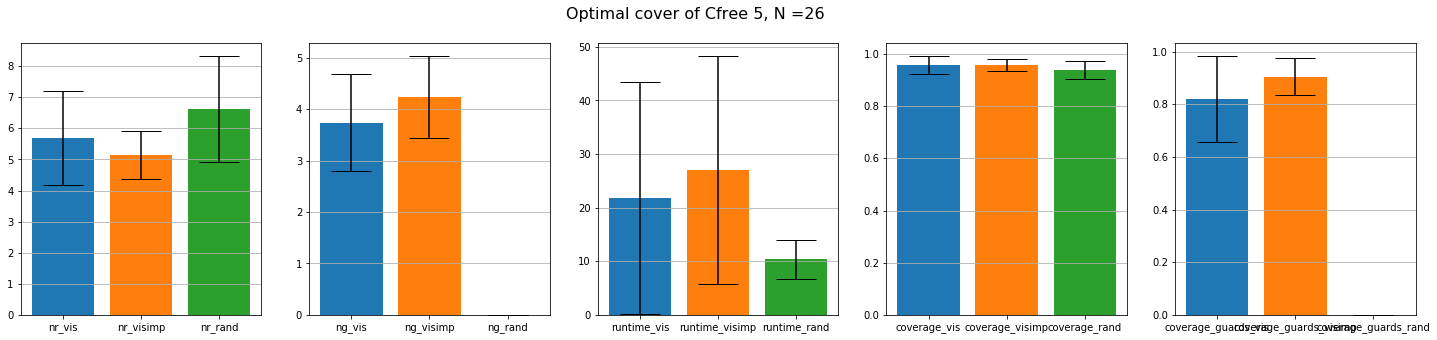

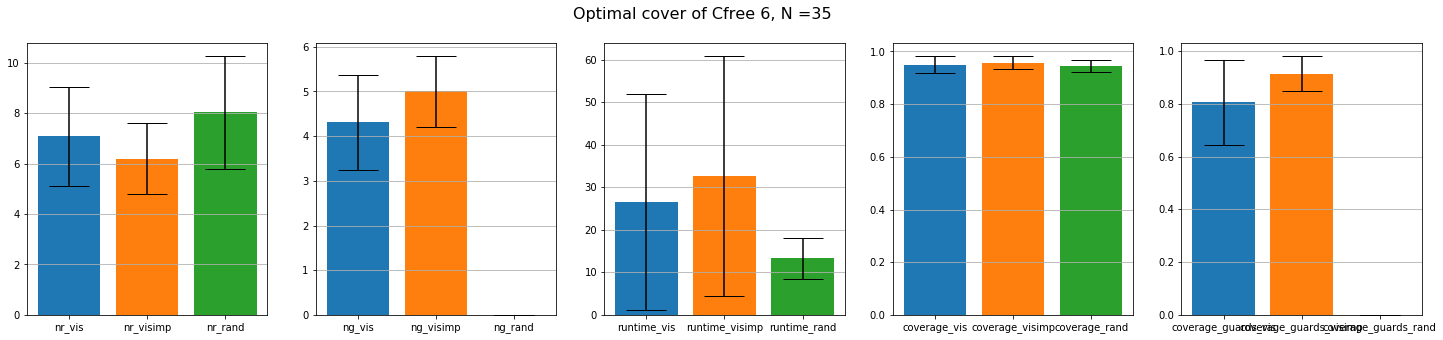

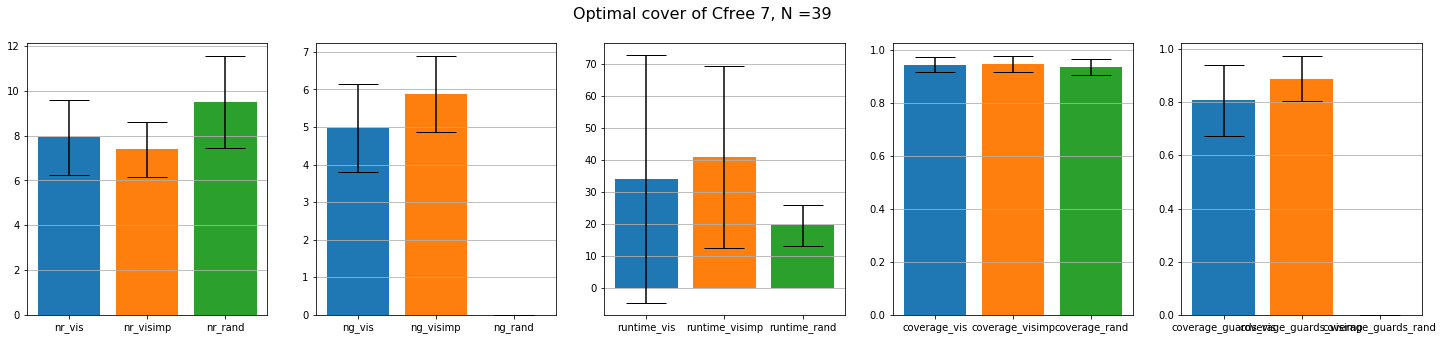

In [360]:
minreg = np.min(vprmseed['optcover'])
maxreg = np.max(vprmseed['optcover'])
for r in (np.arange(maxreg-minreg + 1) + minreg):
    idx_plt = np.where(vprmseed['optcover'] == r )[0]
    idx_plt2 = np.where(np.array(vprm2seed['runtime'])[idx_plt] < 3.5*np.mean(np.array(vprm2seed['runtime'])[idx_plt]))[0]
    print('outliers:', len(idx_plt)-len(idx_plt2))
    #idx_plt = idx_plt[idx_plt2]
    fig, axs = plt.subplots(nrows = 1, ncols = len(joint_keys), figsize = (25, 5))
    for ax, key in zip(axs, joint_keys):
        nfields = 3
        xpos = np.arange(nfields)
        labels = [key+'_vis',key+'_visimp', key+'_rand']
        data_mean = [np.mean(np.array(vprmseed[key])[idx_plt]*1.0),
                     np.mean(np.array(vprm2seed[key])[idx_plt]*1.0),
                     np.mean(np.array(randseed[key])[idx_plt]*1.0)]
        data_std = [np.std(np.array(vprmseed[key])[idx_plt]*1.0),
                    np.std(np.array(vprm2seed[key])[idx_plt]*1.0),
                    np.std(np.array(randseed[key])[idx_plt]*1.0)]
        ax.bar(xpos, data_mean, yerr = data_std,color=['#1f77b4','#ff7f0e', '#2ca02c'], ecolor='black', capsize=20)
        ax.set_xticks(xpos)
        ax.set_xticklabels(labels)
        #if key == 'nr':
            #minor_ticks = np.arange(0, np.max(np.array(randseed[key])[idx_plt]*1.0))
            #ax.set_yticks(minor_ticks, minor=True)
            #major_ticks = np.arange(0, int(np.max(np.array(randseed[key])[idx_plt]*1.0)/2),2)
            #ax.set_yticks(minor_ticks, minor=True)
            #ax.set_yticks(major_ticks)
            #ax.grid(which='minor', alpha=0.5)
            #ax.set_yticklabels([str(l) for l in major_ticks])
        ax.grid(axis = 'y')
        #ax.grid(which='major', alpha=0.9)
        
    fig.suptitle('Optimal cover of Cfree '+ str(r)+', N ='+str(len(idx_plt)), fontsize=16)

[22:41:12] [VPRMSeeding] Expecting points of interest in q
[22:41:12] [VPRMSeeding] GuardInsertion attempts M: 58
[22:41:12] [VPRMSeeding] 0.95 probability that unseen region is less than 5.0 "%" of Cfree 


In [19]:
vs.guard_phase()

[22:42:38] [VPRMSeeding] New guard placed N =  0 it =  0
[22:42:40] [VPRMSeeding] Sample set size 0
[22:42:40] [VPRMSeeding] New guard placed N =  1 it =  1
[22:42:42] [VPRMSeeding] Sample set size 0
[22:42:42] [VPRMSeeding] New guard placed N =  2 it =  2
[22:42:43] [VPRMSeeding] Sample set size 1
[22:42:44] [VPRMSeeding] New guard placed N =  3 it =  3
[22:42:46] [VPRMSeeding] Sample set size 3


[VPRMSeeding] N =  1  guards to split
[VPRMSeeding] N =  1  guards to split
[VPRMSeeding] Splitting guard  1 / 1


In [21]:
kers = [vs.compute_kernel_of_guard(g) for g in vs.guard_regions]


In [22]:
kers

[None, None, None, None, None]

In [231]:
np.array(vprm2seed['runtime'])[np.where(np.array(vprmseed['optcover'])==8)[0]]

array([ 48.6236,  23.0327,  17.0786,  41.2813,  14.2204,  20.2719,
        11.0731,   2.4335, 198.4149,  17.3305,  11.6248,  26.3205,
        16.6353,  17.7803,  16.7957,  17.3523,  22.4271,  16.5182,
        22.6369,  74.8311,  15.882 ,   4.9132,  18.3519,  21.0962,
        10.9409,  66.7331,  17.0792])

In [144]:
 np.array([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]])

array([[ 0.28465179, -0.95863098],
       [ 0.95863098,  0.28465179]])

In [145]:
np.array([[a, 0], [0, b]]) @ np.array([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]])

<ipython-input-145-86ba80001d67>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([[a, 0], [0, b]]) @ np.array([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]])


TypeError: can't multiply sequence by non-int of type 'float'

Latex: a^2

300.0

In [96]:
maxsize.A().shape

(2, 1)

In [333]:
e = region.MaximumVolumeInscribedEllipsoid()

In [335]:
e.center()
e.A()

array([[ 0.68150551, -0.17727269],
       [-0.17727269,  0.73182934]])